In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_size = 224
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs = 30
num_classes = 31

In [4]:
import torchvision.transforms as transforms
transformer = transforms.Compose([
    torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms(),
    transform.Resize(image_size),
])

In [5]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset

DATASET_DIR = '/home/crueang/Tkong/Aiot/Office-31'

amazon_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/amazon', transform=transformer)


dslr_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transformer)


webcam_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/webcam', transform=transformer)


classes = webcam_dataset.classes

Dl_amazon_dataset_mix = DataLoader(amazon_dataset, batch_size, shuffle=True, num_workers=2)
Dl_dslr_dataset_mix = DataLoader(dslr_dataset, batch_size, shuffle=True, num_workers=2)
Dl_webcam_dataset_mix = DataLoader(webcam_dataset, batch_size, shuffle=True, num_workers=2)

# Ds_source, Ds_target = random_split(labled_dataset, [0.5, 0.5])

Ds_amazon_source, Ds_amazon_target, Ds_amazon_test = random_split(amazon_dataset, [0.45, 0.45, 0.1])
Dl_amazon_source = DataLoader(Ds_amazon_source, batch_size, shuffle=True, num_workers=2)
Dl_amazon_target = DataLoader(Ds_amazon_target, batch_size, shuffle=True, num_workers=2)

Ds_dslr_source, Ds_dslr_target, Ds_dslr_test = random_split(dslr_dataset, [0.45, 0.45, 0.1])
Dl_dslr_source = DataLoader(Ds_dslr_source, batch_size, shuffle=True, num_workers=2)
Dl_dslr_target = DataLoader(Ds_dslr_target, batch_size, shuffle=True, num_workers=2)

Ds_webcam_source, Ds_webcam_target, Ds_webcam_test = random_split(webcam_dataset, [0.45, 0.45, 0.1])
Dl_webcam_source = DataLoader(Ds_webcam_source, batch_size, shuffle=True, num_workers=2)
Dl_webcam_target = DataLoader(Ds_webcam_target, batch_size, shuffle=True, num_workers=2)

In [6]:
Ds_source = ConcatDataset([Ds_amazon_source, Ds_dslr_source, Ds_webcam_source])
Ds_target = ConcatDataset([Ds_amazon_target, Ds_dslr_target, Ds_webcam_target])
Ds_test = ConcatDataset([Ds_amazon_test, Ds_dslr_test, Ds_webcam_test])

Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)
Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
Dl_test = DataLoader(Ds_test, batch_size, shuffle=True, num_workers=2)

In [7]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
teacher_model = torch.load('/home/crueang/Chaks/AIOT_project/best_resnet_amazon.pth', weights_only=False, map_location=device)
teacher_model.eval()
model = torchvision.models.mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

In [9]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [10]:
class CorrelationAlignmentLoss(nn.Module):
    
    def __init__(self):
        super(CorrelationAlignmentLoss, self).__init__()

    def forward(self, f_s: torch.Tensor, f_t: torch.Tensor) -> torch.Tensor:
        mean_s = f_s.mean(0, keepdim=True)
        mean_t = f_t.mean(0, keepdim=True)
        cent_s = f_s - mean_s
        cent_t = f_t - mean_t
        cov_s = torch.mm(cent_s.t(), cent_s) / (len(f_s) - 1)
        cov_t = torch.mm(cent_t.t(), cent_t) / (len(f_t) - 1)

        mean_diff = (mean_s - mean_t).pow(2).mean()
        cov_diff = (cov_s - cov_t).pow(2).mean()

        return mean_diff + cov_diff

In [11]:
lambda_coral = 1.0

# loss_fn_class = torch.nn.NLLLoss()
# loss_fn_domain = torch.nn.NLLLoss()
loss_amazon = torch.nn.CrossEntropyLoss()
loss_dslr = torch.nn.CrossEntropyLoss()
loss_webcam = torch.nn.CrossEntropyLoss()

loss_fn_class = torch.nn.CrossEntropyLoss()
    
# Training the same number of batches from both datasets
max_batches = max(len(Dl_amazon_source), len(Dl_dslr_source), len(Dl_webcam_source))
print(max_batches)

# network

model = torchvision.models.mobilenet_v3_small(n_C=num_classes, weights=True).to(device)
optimizer = optim.Adam(model.parameters(), lr)
summary(model, input_size=(channel_size, image_size, image_size))

80


/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [12]:
def cal_loss(Dl_s_iter, Dl_t_iter, loss_subdomain):
    X_s, y_s = next(Dl_s_iter)
    X_t, y_t = next(Dl_t_iter)
    
    X_s, y_s = X_s.to(device), y_s.to(device)
    X_t, y_t = X_t.to(device), y_t.to(device)
    
    class_pred_s = model(X_s)
    class_pred_t = model(X_t)
    
    loss_src = loss_subdomain(class_pred_s, y_s)
    loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
    loss = loss_src + loss_coral
    
    return loss

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import mobilenet_v3_large,mobilenet_v3_small
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import torchvision
from torch.utils.data import Dataset
class DistillKL(nn.Module):
    """
      Arg:
      Distilling the Knowledge in a Neural Network
    """
    def __init__(self, Temperature):
        super(DistillKL, self).__init__()
        self.Temperature = Temperature

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.Temperature, dim=1)
        #p_s = F.softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.Temperature, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        return loss
    
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

def mmdloss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

In [14]:
import torch
from tqdm import tqdm
def train_student_2(student_model,teacher_model, opt, loss_fn, Dl_source,Dl_target ,test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    training_logs = {"train_loss": [], "validate_loss": [], "train_acc": [], "validate_acc": [],'train_src_acc':[],'train_tar_acc':[]}
    epoch_number = 0
    best_test_loss = float('inf')
    student_model = student_model.to(device)
    # alpha_loss = 0.1
    if checkpoint_path:
      if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
      if os.path.exists(checkpoint_path + 'model.pth'):
        student_model.load_state_dict(torch.load(checkpoint_path + 'model.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'opt.pth'):
        opt.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['validate_loss']))

    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()

    print("🤖Training on", device)
    max_batch = min(len(Dl_source),len(Dl_target))
    stored_lbs_tar = torch.empty(0, dtype=torch.float32)
    stored_preds_tar = torch.empty(0, dtype=torch.float32)
    for epoch in range(epoch_number, epochs):

        train_loss, train_correct,mmd,kd = 0, 0,0,0
        train_s_correct = 0
        student_model.train()
        print(f'epochs {epoch+1:04d} / {epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)
        p = (epoch + 1) / epochs
        # alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        for batch_idx in range(max_batch):
            
            opt.zero_grad()
            X_s, y_s = next(Dl_source_iter)

            X_t, y_t = next(Dl_target_iter)

            if X_s.shape[0] != X_t.shape[0]:
              min_bs = min(X_s.shape[0], X_t.shape[0])
              X_s = X_s[:min_bs]
              y_s = y_s[:min_bs]
              X_t = X_t[:min_bs]
              y_t = y_t[:min_bs]
            
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)

            with torch.no_grad():
                outputs_teacher = teacher_model(X_t)

            class_pred_s = student_model(X_s)
            class_pred_t = student_model(X_t)

            kd_loss = DistillKL(Temperature=3.0)(class_pred_t,outputs_teacher)

            loss_src = loss_fn(class_pred_s, y_s) 
            mmd_loss = mmdloss(class_pred_s, class_pred_t)

            loss =loss_src + mmd_loss*0.1 + kd_loss*1
            loss.backward()
            opt.step()
            # stored_lbs_tar = torch.cat((stored_lbs_tar.to(device), y_t), 0)
            # _, prediction_t = torch.max(class_pred_t, 1)
            # stored_preds_tar = torch.cat((stored_preds_tar.to(device), prediction_t), 0)
            train_loss += loss.item()
            mmd += mmd_loss.item()
            with torch.no_grad():
                class_prediction_S = student_model(X_s)
                train_correct_s = (class_prediction_S.argmax(1) == y_s).float().sum().item()
                class_prediction_T = student_model(X_t)
                train_correct_t = (class_prediction_T.argmax(1) == y_t).float().sum().item()
            train_s_correct +=  train_correct_s
            train_correct += train_correct_t

        avg_train_loss = train_loss / (16*max_batch)
        avg_train_acc = train_correct / (16*max_batch)
        print(f'\n\tTrain loss: {avg_train_loss}')
        print(f'\tTrain acc: {avg_train_acc}')
        training_logs["train_loss"].append(avg_train_loss)
        training_logs["train_acc"].append(avg_train_acc)
        training_logs["train_src_acc"].append(train_s_correct/ (16*max_batch))
        training_logs["train_tar_acc"].append(avg_train_acc)
        
        test_loss, test_correct = 0, 0
        student_model.eval()
        test_bar = tqdm(test_loader , desc='📄Testing' , unit='batch')
        with torch.no_grad():
          for images, label in test_bar:
            images = images.to(device)
            label = label.to(device)
            outputs = student_model(images)
            loss = loss_fn(outputs, label)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == label).float().sum().item()

        avg_test_loss = test_loss / len(test_loader.dataset)
        avg_test_acc = test_correct / len(test_loader.dataset)
        print(f'\tTest loss: {avg_test_loss}')
        print(f'\tTest acc: {avg_test_acc}')
        training_logs["validate_loss"].append(avg_test_loss)
        training_logs["validate_acc"].append(avg_test_acc)
        
        if checkpoint_path:
            torch.save(student_model.state_dict(), checkpoint_path + "model.pth")
            torch.save(opt.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > avg_test_loss:
               torch.save(student_model.state_dict(), checkpoint_path + "best_model.pth")
               best_test_loss = avg_test_loss
               
    return stored_lbs_tar,stored_preds_tar

In [15]:
from torch.utils.data import DataLoader, random_split
Ds_amazon, Ds_amazon_test = random_split(amazon_dataset, [0.8, 0.2])
Ds_dslr, Ds_dslr_test = random_split(dslr_dataset, [0.8, 0.2])
Ds_webcam, Ds_webcam_test = random_split(webcam_dataset, [0.8, 0.2])


Dl_amazon = DataLoader(Ds_amazon, 16, shuffle=True, num_workers=2)
Dl_dslr = DataLoader(Ds_dslr, 16, shuffle=True, num_workers=2)
Dl_webcam = DataLoader(Ds_webcam, 16, shuffle=True, num_workers=2)


Dl_amazon_test = DataLoader(Ds_amazon_test, 16, shuffle=False, num_workers=2)
Dl_dslr_test = DataLoader(Ds_dslr_test, 16, shuffle=False, num_workers=2)
Dl_webcam_test = DataLoader(Ds_webcam_test, 16, shuffle=False, num_workers=2)



In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mbv_3_small_target = mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
mbv_3_small_target.classifier[-1] = nn.Linear(mbv_3_small_target.classifier[-1].in_features, 31)
mbv_3_small_target = mbv_3_small_target.to(device)
criterion = nn.CrossEntropyLoss()
check_point_path = f'/home/crueang/Tkong/Aiot/project/cp/mbv3_small_a_D/'
optimizer = torch.optim.Adam(mbv_3_small_target.parameters(), lr=0.001)
stored_lbs_tar,stored_preds_tar = train_student_2(mbv_3_small_target,teacher_model,optimizer,criterion,Dl_amazon,Dl_dslr,Dl_dslr_test,epochs = 30,checkpoint_path=check_point_path,device=device)

Epochs 1  train_loss: 1.35889 validate_loss: 0.07090 train_acc: 0.69000 validate_acc: 0.63636 train_src_acc: 0.33750 train_tar_acc: 0.69000 
Epochs 2  train_loss: 0.46074 validate_loss: 0.01750 train_acc: 0.95750 validate_acc: 0.89899 train_src_acc: 0.52750 train_tar_acc: 0.95750 
Epochs 3  train_loss: 0.30152 validate_loss: 0.02361 train_acc: 0.99750 validate_acc: 0.89899 train_src_acc: 0.62500 train_tar_acc: 0.99750 
Epochs 4  train_loss: 0.21267 validate_loss: 0.02826 train_acc: 0.99000 validate_acc: 0.98990 train_src_acc: 0.73000 train_tar_acc: 0.99000 
Epochs 5  train_loss: 0.17139 validate_loss: 0.01579 train_acc: 0.99500 validate_acc: 0.94949 train_src_acc: 0.80250 train_tar_acc: 0.99500 
Epochs 6  train_loss: 0.16070 validate_loss: 0.01891 train_acc: 0.99250 validate_acc: 0.97980 train_src_acc: 0.78000 train_tar_acc: 0.99250 
Epochs 7  train_loss: 0.13476 validate_loss: 0.03509 train_acc: 0.99500 validate_acc: 0.94949 train_src_acc: 0.83750 train_tar_acc: 0.99500 
Epochs 8  tra

In [17]:
# @title Function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_scor
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score,adjusted_rand_score
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional, List
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import os.path as osp
import matplotlib
matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)    #office-31
    # plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""

def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7

def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)


"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor,
                             target_feature: torch.Tensor,
                             source_labels: torch.Tensor,
                             target_labels: torch.Tensor,
                             filename: str,
                             source_color='r',
                             target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def Adist_calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device=device)

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            # print(label)
            # print(y)
            # print(label.shape,y.shape)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance



class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class AverageMeterDict(object):
    def __init__(self, names: List, fmt: Optional[str] = ':f'):
        self.dict = {
            name: AverageMeter(name, fmt) for name in names
        }

    def reset(self):
        for meter in self.dict.values():
            meter.reset()

    def update(self, accuracies, n=1):
        for name, acc in accuracies.items():
            self.dict[name].update(acc, n)

    def average(self):
        return {
            name: meter.avg for name, meter in self.dict.items()
        }

    def __getitem__(self, item):
        return self.dict[item]


class Meter(object):
    """Computes and stores the current value."""
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0

    def update(self, val):
        self.val = val

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [18]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score,adjusted_rand_score
from sklearn import metrics
%matplotlib inline
def evaluate_model_performance(stored_lbs_tar, stored_preds_tar, Dl_source, Dl_target, model, device, output_path='Tkong/Aiot/project/output/',file_name="hi.png"):
    # Class labels
    pos_labels = np.arange(31)
    lb_classes = (
        'chair', 'desk', 'computer', 'printer', 'phone', 'lamp', 'book', 'pen', 'paper', 'mouse',
        'keyboard', 'file', 'window', 'door', 'whiteboard', 'projector', 'calendar', 'cup', 'monitor', 
        'trash_can', 'stapler', 'paperclip', 'notepad', 'envelope', 'highlighter', 'scissors', 'calculator', 
        'folder', 'sticky_note', 'clock', 'plant'
    )

    lb = stored_lbs_tar.cpu()
    prd = stored_preds_tar.cpu()

    # --- Confusion Matrix
    cm_target = confusion_matrix(
                            y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true'
                            )
    fig, axs = plt.subplots(figsize=(30 ,20))
    cm = metrics.ConfusionMatrixDisplay(cm_target)
    cm.plot(ax=axs, cmap='Blues')
    plt.show()
    # cm_target = confusion_matrix(y_true=lb, y_pred=prd, labels=pos_labels, normalize='true')
    
    # plt.figure()
    # plt.rcParams.update({'font.size': 10, 'figure.figsize': (2, 2)})
    # plot_confusion_matrix(cm_target,
    #                       classes=lb_classes,
    #                       normalize=True,
    #                       title='Conf. Mat. w.r.t. CIFAR-10 ds',
    #                       cmap=plt.cm.binary)
    
    # --- F1-score/Precision/Recall scores
    precision, recall, f1, _ = precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0, beta=1.0)
    print("Precision:", precision, "Recall:", recall, "F1-score:", f1)

    # --- Normalized Mutual Information (NMI) score
    nmi_score = normalized_mutual_info_score(labels_true=lb, labels_pred=prd, average_method='arithmetic')
    
    # --- Rand Index (RI) score
    ri_score = adjusted_rand_score(labels_true=lb, labels_pred=prd)
    print(f"NMI score: {nmi_score}, RI score: {ri_score}")

    # --- Collect features
    source_feature, s_labels = collect_feature(Dl_source, model.to(device), device)
    target_feature, t_labels = collect_feature(Dl_target, model.to(device), device)

    # --- Calculate A-distance
    # with torch.no_grad():
    #     for data in Dl_dslr:
    #         images, labels = data
    #         images, labels = images.to(device), labels.to(device)
    #         outputs = model(images)


    #         loss = criterion(outputs, labels)

    #         test_loss += loss.item()

    A_distance = Adist_calculate(source_feature, target_feature, device)
    print("A-distance =", A_distance)

    # --- Plot t-SNE
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    tSNE_filename = os.path.join(output_path, file_name)
    visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)
    print("Saving t-SNE to", tSNE_filename)

📄Testing: 100%|██████████| 32/32 [00:04<00:00,  6.87batch/s]


	Test loss: 0.0011715993493917303
	Test acc: 0.9919678714859438


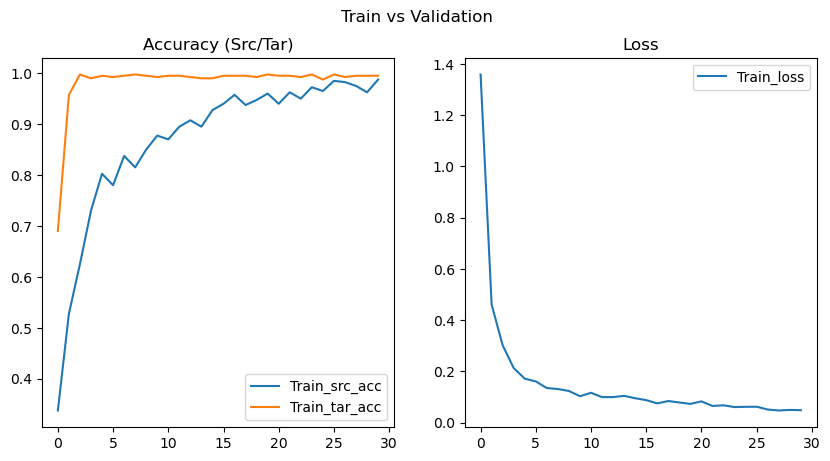

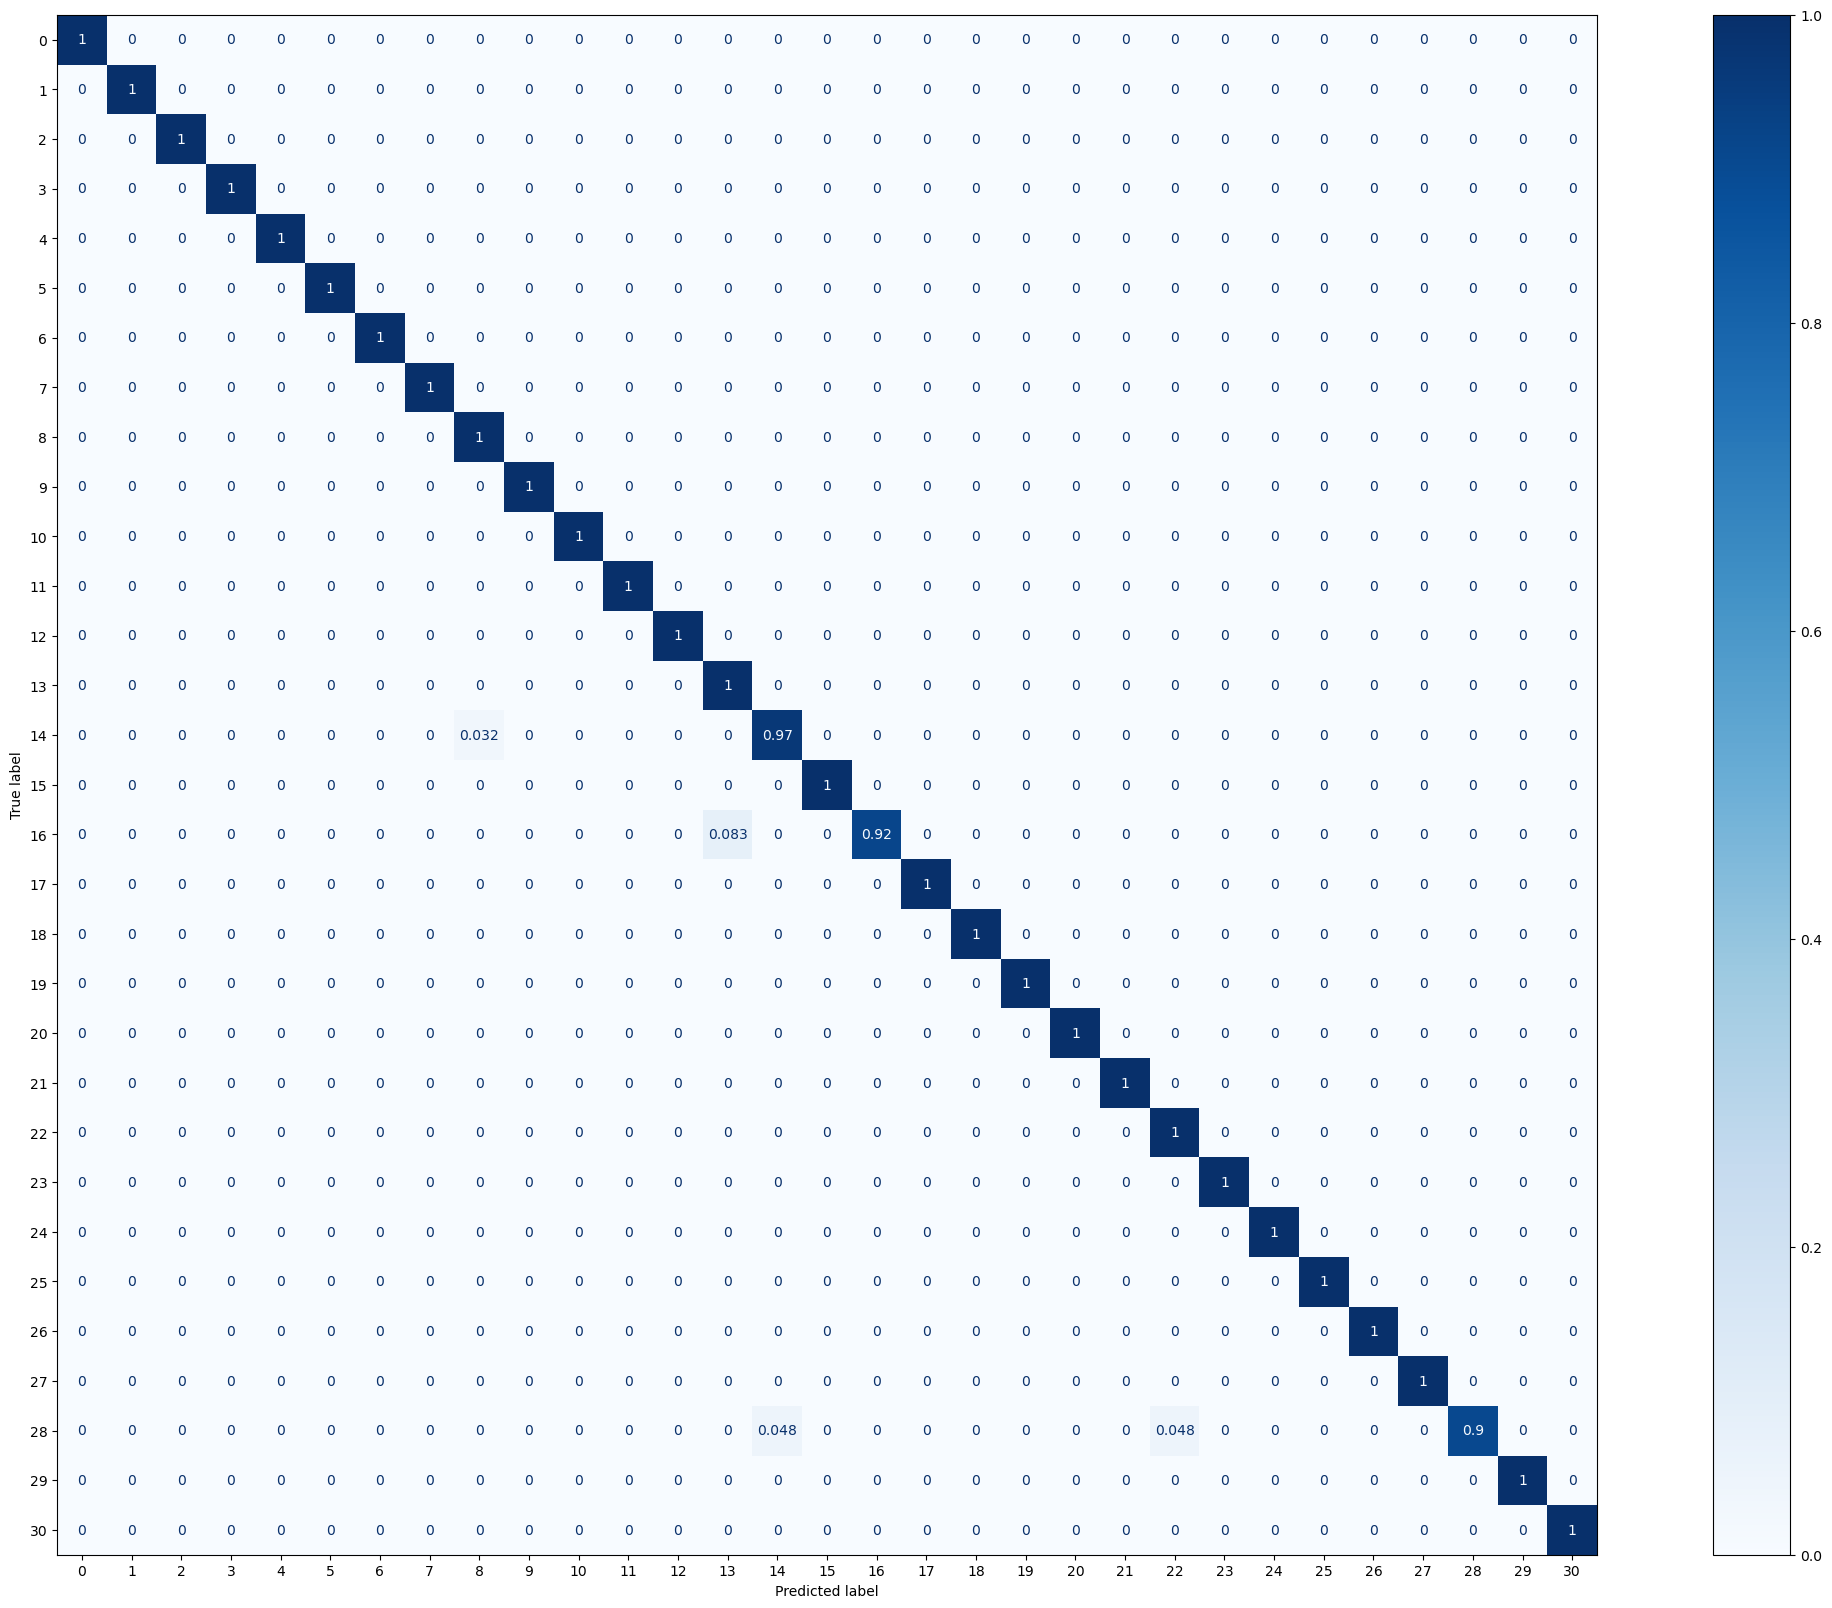

Precision: 0.9922951610363021 Recall: 0.9919678714859438 F1-score: 0.9919079913952753
NMI score: 0.9904807488423698, RI score: 0.9800784699420227


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


epoch 0 accuracy: 87.48114776611328 A-dist: 1.4992458820343018
epoch 1 accuracy: 86.1236801147461 A-dist: 1.4449472427368164
epoch 2 accuracy: 88.08446502685547 A-dist: 1.523378610610962
epoch 3 accuracy: 85.5203628540039 A-dist: 1.4208145141601562
epoch 4 accuracy: 89.89441680908203 A-dist: 1.5957765579223633
epoch 5 accuracy: 89.59275817871094 A-dist: 1.5837104320526123
epoch 6 accuracy: 90.19607543945312 A-dist: 1.6078429222106934
epoch 7 accuracy: 88.68778228759766 A-dist: 1.547511339187622
epoch 8 accuracy: 76.77224731445312 A-dist: 1.070889949798584
epoch 9 accuracy: 90.64856719970703 A-dist: 1.6259427070617676
A-distance = tensor(1.6259)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff4bd2e9080>
Traceback (most recent call last):
  File "/home/crueang/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/crueang/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/crueang/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/crueang/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no 

Saving t-SNE to /home/crueang/Tkong/Aiot/project/output/tSNE_a_D.png


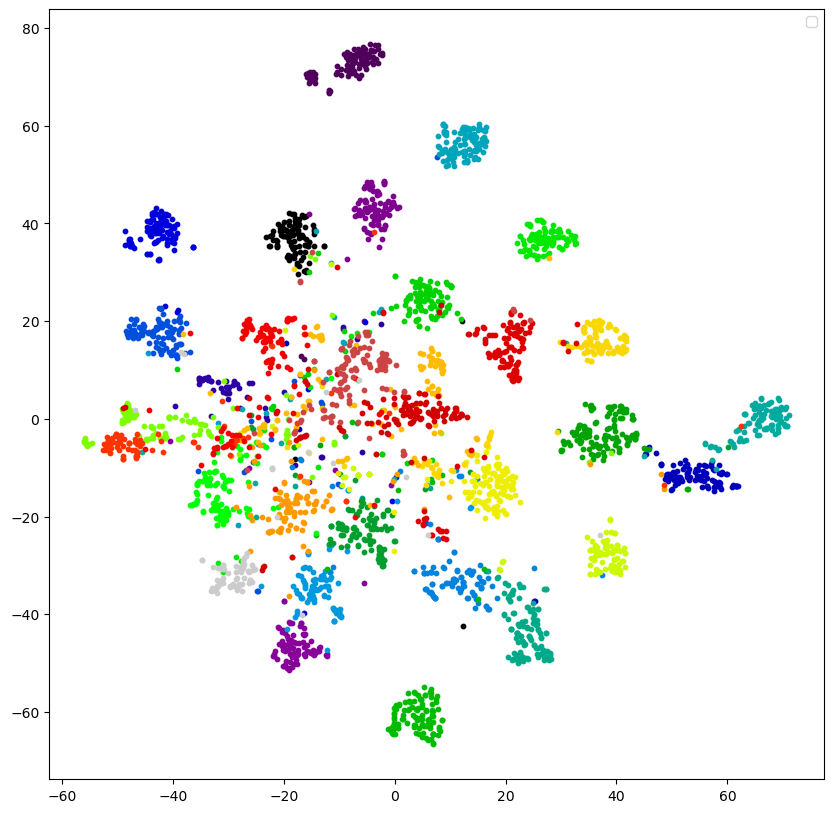

In [27]:
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nam_model = mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
nam_model.classifier[-1] = nn.Linear(nam_model.classifier[-1].in_features, 31)
check_point_path = '/home/crueang/Tkong/Aiot/project/cp/mbv3_small_a_D/'
nam_model.load_state_dict(torch.load(check_point_path+'best_model.pth', weights_only=True))
training_logs = torch.load(check_point_path + 'training_logs.pth', weights_only=True)
# nam_model = torch.load('/home/crueang/Chaks/AIOT_project/cp/baseline/mbv3_small_ref2/best_model.pth',weights_only=False, map_location=device)

nam_model = nam_model.to(device)

stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)
criterion = nn.CrossEntropyLoss()
# Dl_amazon_dataset_mix = DataLoader(dslr_dataset,16,True)
# nam_model = nam_model.to(device)
nam_model.eval()
for i in range(1):
    test_loss , test_correct = 0,0
    test_bar = tqdm(Dl_dslr_dataset_mix , desc='📄Testing' , unit='batch')
    with torch.no_grad():
        for images, label in test_bar:
            images = images.to(device)
            label = label.to(device)
            outputs = nam_model(images)
            loss = criterion(outputs, label)
            
            stored_lbs_tar = torch.cat((stored_lbs_tar.to(device), label), 0)
            _, prediction_t = torch.max(outputs, 1)
            stored_preds_tar = torch.cat((stored_preds_tar.to(device), prediction_t), 0)
            
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == label).float().sum().item()

    avg_test_loss = test_loss / len(Dl_dslr_dataset_mix.dataset)
    avg_test_acc = test_correct / len(Dl_dslr_dataset_mix.dataset)
    print(f'\tTest loss: {avg_test_loss}')
    print(f'\tTest acc: {avg_test_acc}')
    a_distance = 2 * (1 - 2 * (1-avg_test_acc))

device="cpu"
plot_graph(training_logs)
evaluate_model_performance(stored_lbs_tar,stored_preds_tar,Dl_amazon_dataset_mix,Dl_dslr_dataset_mix,nam_model,device,"/home/crueang/Tkong/Aiot/project/output/","tSNE_a_D.png")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")